# 02 — Bitcoin Research: Backtests + Model Ensembles (IBIT)

Goal:
- Trade IBIT long-only using 4 core BTC-driven models:
  - OU, Mining, ZScore, Trend
- Compare vs AMMA and Buy & Hold
- Find best combinations:
  - 4 choose 1, 2, 3, 4
  - Grand combo (all 4, weights must be non-zero)
  - 5-model combo (4 + AMMA, weights must be non-zero)
- Try non-linear combos (gating / activation)
- Final cell: summary chart + conclusion

Constraints:
- Long-only
- No leverage (final position always in [0,1])
- No lookahead (engine shifts position by 1 day)
- 365-day annualization

In [1]:
# --- Project path setup (run first) ---
import sys
from pathlib import Path

ROOT = Path.cwd()
if (ROOT / "config.py").exists():
    PROJECT_ROOT = ROOT
elif (ROOT.parent / "config.py").exists():
    PROJECT_ROOT = ROOT.parent
else:
    PROJECT_ROOT = ROOT

sys.path.insert(0, str(PROJECT_ROOT))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from itertools import combinations, product

from config import *
from Data.raw_data_loader import load_ibit_with_mining_cost

from Backtest.engine import run_backtest
from Backtest.metrics import build_summary_table

from Models.amma import amma_signal
from Models.zscore import zscore_signal
from Models.trend import trend_signal
from Models.ou import ou_signal
from Models.mining import mining_signal

In [2]:
# --- Load IBIT + mining cost aligned ---
df = load_ibit_with_mining_cost(
    ibit_path=IBIT_PATH,
    cleaned_crypto_path=DATA_PATH,
    forward_fill_mining_cost=True,
).rename(columns={"close": PRICE_COLUMN_IBIT, "mining_cost": COST_COLUMN_MINE})

price_col = PRICE_COLUMN_IBIT

# basic sanity
df[[price_col, COST_COLUMN_MINE]] = df[[price_col, COST_COLUMN_MINE]].astype(float)

print("Date range:", df.index.min(), "->", df.index.max())
print("Rows:", len(df))
print("Columns:", list(df.columns))
display(df.head())

Date range: 2024-01-11 00:00:00 -> 2026-02-25 00:00:00
Rows: 532
Columns: ['IBIT_close', 'COST_TO_MINE']


,IBIT_close,COST_TO_MINE
date,,
2024-01-11,26.63,38865.4335
2024-01-12,24.97,39503.8137
2024-01-16,24.72,36461.3437
2024-01-17,24.41,37085.1762
2024-01-18,23.34,38133.0705


In [3]:
def bt(position: pd.Series, name: str) -> dict:
    """
    Runs backtest with NO LEVERAGE (long_only + leverage_cap=1.0).
    Engine shifts by 1 day and clips.
    """
    position = position.reindex(df.index).fillna(0.0).astype(float).clip(0.0, 1.0)

    res = run_backtest(
        df=df,
        price_col=price_col,
        position=position,
        fee_bps=FEE_BPS,
        slippage_bps=SLIPPAGE_BPS,
        annual_borrow_rate=ANNUAL_BORROW_RATE,
        long_only=True,
        leverage_cap=1.0,
    )
    res["name"] = name
    return res


def plot_equity(results_dict: dict, title: str):
    plt.figure(figsize=(12, 5))
    for name, res in results_dict.items():
        plt.plot(res["net_equity"].index, res["net_equity"].values, label=name)
    plt.title(title)
    plt.legend()
    plt.show()

In [4]:
# --- Baselines ---
def pos_buyhold(d: pd.DataFrame) -> pd.Series:
    return pd.Series(1.0, index=d.index)

def pos_amma(d: pd.DataFrame) -> pd.Series:
    return amma_signal(
        d,
        price_column=price_col,
        momentum_weights={20: 0.25, 60: 0.25, 120: 0.25, 252: 0.25},
        threshold=0.0,
        normalize_weights=True,   # guarantees [0,1]
    )

# --- Core models (all long-only, UN-SHIFTED) ---
def pos_zscore(d: pd.DataFrame) -> pd.Series:
    vol_target = VOL_TARGET if USE_VOL_TARGET else None
    return zscore_signal(
        price_series=d[price_col],
        window=ZSCORE_WINDOW,
        entry_z=ZSCORE_ENTRY_Z,
        exit_z=ZSCORE_EXIT_Z,
        long_short=False,
        max_leverage=1.0,
        vol_window=VOL_WINDOW,
        vol_target=vol_target,
    )


def pos_trend(d: pd.DataFrame) -> pd.Series:
    return trend_signal(
        d,
        price_column=price_col,
        mode="faber_10m",     # try "tsmom_12m" too
        ma_months=10,
        exposure_on=1.0,
        exposure_off=0.0,
    )

def pos_ou(d: pd.DataFrame) -> pd.Series:
    return ou_signal(
        price_series=d[price_col],
        window=OU_WINDOW,
        entry_z=OU_ENTRY_Z,
        exit_z=OU_EXIT_Z,
        long_short=False,
    )

def pos_mining(d: pd.DataFrame) -> pd.Series:
    return mining_signal(
        d,
        price_column=price_col,
        cost_column=COST_COLUMN_MINE,
        z_window=MINING_Z_WINDOW,
        entry_z=MINING_ENTRY_Z,
        exit_z=MINING_EXIT_Z,
        use_log_edge=MINING_USE_LOG_EDGE,
    )

CORE_MODELS = {
    "ou": pos_ou,
    "mining": pos_mining,
    "zscore": pos_zscore,
    "trend": pos_trend,
}

BASELINES = {
    "buyhold": pos_buyhold,
    "amma": pos_amma,
}

,Sharpe,Sortino,CAGR,MaxDD,Calmar,AnnualReturn,AnnualVol,Observations,AnnualTurnover
Strategy,,,,,,,,,
buyhold,0.736363,1.209655,0.303034,-0.493618,0.613904,0.455699,0.618852,532,0.686090
amma,0.569826,0.842020,0.137738,-0.225728,0.610195,0.177002,0.310624,532,17.838346
trend,0.534485,0.656495,0.143292,-0.327115,0.438050,0.211741,0.396160,532,1.372180
mining,0.186367,0.181612,-0.009559,-0.348846,-0.027401,0.078134,0.419249,532,2.744361
ou,-0.292029,-0.158256,-0.104788,-0.348846,-0.300385,-0.076322,0.261351,532,2.058271
zscore,-0.396171,-0.098437,-0.079834,-0.184878,-0.431820,-0.068124,0.171955,532,0.686090


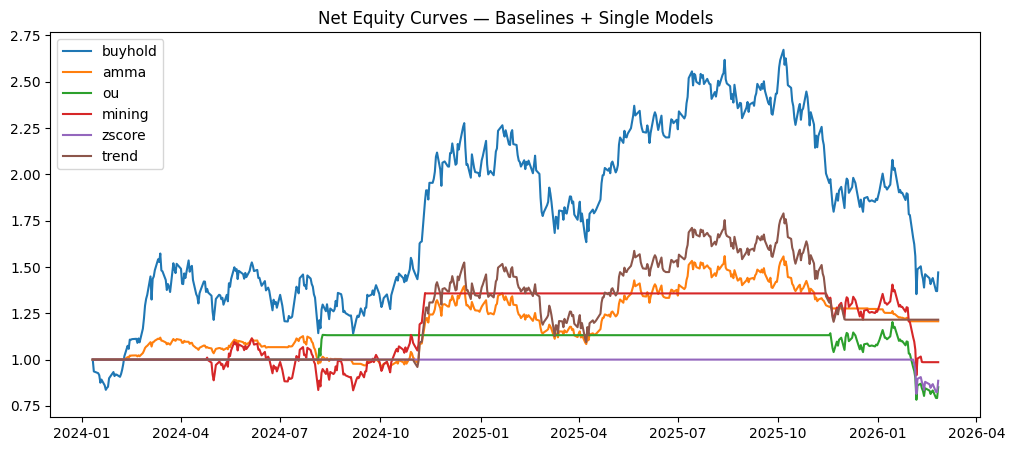

In [5]:
results = {}

# baselines
for name, fn in BASELINES.items():
    pos = fn(df).clip(0.0, 1.0)
    results[name] = bt(pos, name)

# singles
for name, fn in CORE_MODELS.items():
    pos = fn(df).clip(0.0, 1.0)
    results[name] = bt(pos, name)

table = build_summary_table({
    k: {"returns": v["net_returns"], "position": v["position"]}
    for k, v in results.items()
})

display(table.sort_values("Sharpe", ascending=False))
plot_equity(results, "Net Equity Curves — Baselines + Single Models")

In [6]:
def weight_grid(n: int, step: float, require_nonzero: bool):
    """
    Generates weight vectors w of length n such that:
      - w_i in {0, step, 2*step, ..., 1}
      - sum(w) == 1
      - if require_nonzero: each w_i >= step
    """
    step = float(step)
    vals = np.arange(0.0, 1.0 + 1e-12, step)

    min_w = step if require_nonzero else 0.0

    for w in product(vals, repeat=n):
        if abs(sum(w) - 1.0) > 1e-9:
            continue
        if any(x < min_w for x in w):
            continue
        yield np.array(w, dtype=float)


def linear_combo(positions: list[pd.Series], weights: np.ndarray) -> pd.Series:
    """
    Linear combo with weights summing to 1.

    If each position is in [0,1] and weights sum to 1, the combo is in [0,1].
    We still clip as a safety net.
    """
    combo = pd.Series(0.0, index=df.index)
    for w, p in zip(weights, positions):
        combo = combo + float(w) * p.reindex(df.index).fillna(0.0).astype(float).clip(0.0, 1.0)
    return combo.clip(0.0, 1.0)

In [7]:
# Cache model positions once (faster + consistent)
core_pos = {m: CORE_MODELS[m](df).clip(0.0, 1.0) for m in CORE_MODELS}
base_pos = {b: BASELINES[b](df).clip(0.0, 1.0) for b in BASELINES}


def best_combo_for_subset(model_names, step=0.1, require_nonzero=False):
    """
    Finds best Sharpe linear combo for a given subset of models.
    """
    model_names = list(model_names)
    pos_list = [core_pos[m] for m in model_names]

    best = None
    for w in weight_grid(len(model_names), step=step, require_nonzero=require_nonzero):
        combo_pos = linear_combo(pos_list, w)
        res = bt(combo_pos, name=f"combo({'+'.join(model_names)})")
        sharpe = res["net_returns"].mean() * DAYS_PER_YEAR / (res["net_returns"].std(ddof=1) * np.sqrt(DAYS_PER_YEAR)) if res["net_returns"].std(ddof=1) > 0 else np.nan

        if not np.isfinite(sharpe):
            continue
        if (best is None) or (sharpe > best["sharpe"]):
            best = {
                "models": tuple(model_names),
                "weights": w,
                "sharpe": float(sharpe),
                "result": res,
            }
    return best


# Evaluate 4 choose k
model_list = list(core_pos.keys())
combo_bests = []

for k in [1, 2, 3, 4]:
    for subset in combinations(model_list, k):
        if k == 1:
            m = subset[0]
            # treat single model as best "combo" with weight 1
            res = bt(core_pos[m], name=m)
            sharpe = res["net_returns"].mean() * DAYS_PER_YEAR / (res["net_returns"].std(ddof=1) * np.sqrt(DAYS_PER_YEAR)) if res["net_returns"].std(ddof=1) > 0 else np.nan
            combo_bests.append({"models": subset, "weights": np.array([1.0]), "sharpe": float(sharpe), "result": res})
        else:
            best = best_combo_for_subset(subset, step=0.1, require_nonzero=False)
            if best is not None:
                combo_bests.append(best)

combo_bests = sorted(combo_bests, key=lambda x: x["sharpe"], reverse=True)
best_any_subset = combo_bests[0]

print("Best subset combo:", best_any_subset["models"])
print("Weights:", best_any_subset["weights"])
print("Sharpe:", best_any_subset["sharpe"])

results["best_subset_combo"] = best_any_subset["result"]

Best subset combo: ('mining', 'trend')
Weights: [0.1 0.9]
Sharpe: 0.5419651462018975


In [8]:
best_grand = best_combo_for_subset(model_list, step=0.1, require_nonzero=True)

print("Best grand combo (all 4, non-zero weights):", best_grand["models"])
print("Weights:", best_grand["weights"])
print("Sharpe:", best_grand["sharpe"])

results["grand_combo"] = best_grand["result"]

Best grand combo (all 4, non-zero weights): ('ou', 'mining', 'zscore', 'trend')
Weights: [0.1 0.1 0.1 0.7]
Sharpe: 0.480425076964001


In [9]:
def best_combo_with_amma(step=0.1, require_nonzero=True):
    names = ["ou", "mining", "zscore", "trend", "amma"]
    pos_list = [core_pos["ou"], core_pos["mining"], core_pos["zscore"], core_pos["trend"], base_pos["amma"]]

    best = None
    for w in weight_grid(len(names), step=step, require_nonzero=require_nonzero):
        combo_pos = linear_combo(pos_list, w)
        res = bt(combo_pos, name="combo5(ou+mining+zscore+trend+amma)")
        sharpe = res["net_returns"].mean() * DAYS_PER_YEAR / (res["net_returns"].std(ddof=1) * np.sqrt(DAYS_PER_YEAR)) if res["net_returns"].std(ddof=1) > 0 else np.nan

        if not np.isfinite(sharpe):
            continue
        if (best is None) or (sharpe > best["sharpe"]):
            best = {"models": tuple(names), "weights": w, "sharpe": float(sharpe), "result": res}

    return best


best5 = best_combo_with_amma(step=0.1, require_nonzero=True)

print("Best 5-model combo weights:", best5["weights"])
print("Sharpe:", best5["sharpe"])

results["combo5"] = best5["result"]

Best 5-model combo weights: [0.1 0.1 0.1 0.3 0.4]
Sharpe: 0.49811322744852377


,Sharpe,Sortino,CAGR,MaxDD,Calmar,AnnualReturn,AnnualVol,Observations,AnnualTurnover
Strategy,,,,,,,,,
buyhold,0.736363,1.209655,0.303034,-0.493618,0.613904,0.455699,0.618852,532,0.686090
amma,0.569826,0.842020,0.137738,-0.225728,0.610195,0.177002,0.310624,532,17.838346
best_subset_combo,0.541965,0.716226,0.141169,-0.318820,0.442786,0.198381,0.366040,532,1.509398
trend,0.534485,0.656495,0.143292,-0.327115,0.438050,0.211741,0.396160,532,1.372180
combo5,0.498113,0.771685,0.099868,-0.263978,0.378319,0.127898,0.256764,532,7.958647
grand_combo,0.480425,0.654526,0.103534,-0.301888,0.342953,0.141588,0.294714,532,1.509398
mining,0.186367,0.181612,-0.009559,-0.348846,-0.027401,0.078134,0.419249,532,2.744361
ou,-0.292029,-0.158256,-0.104788,-0.348846,-0.300385,-0.076322,0.261351,532,2.058271
zscore,-0.396171,-0.098437,-0.079834,-0.184878,-0.431820,-0.068124,0.171955,532,0.686090


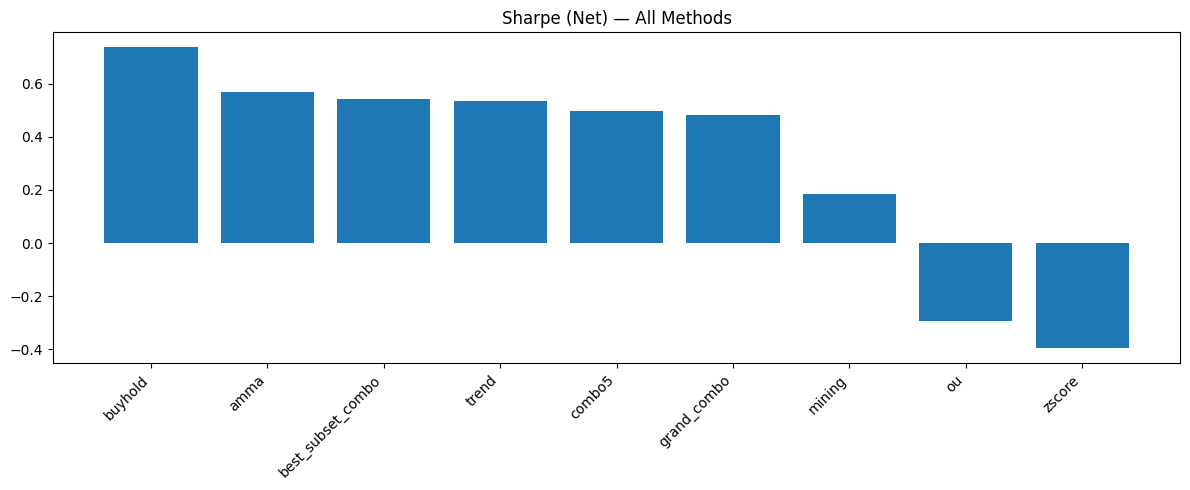

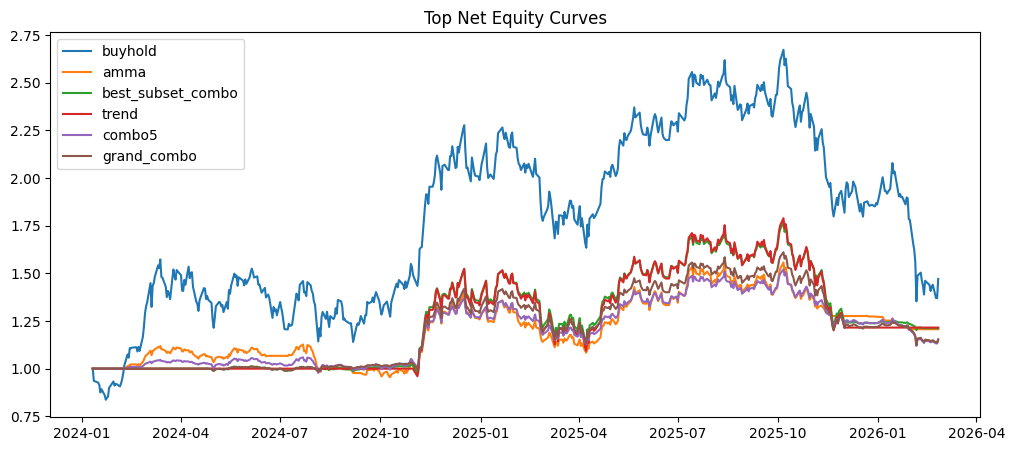

Best method by Sharpe: buyhold

Conclusion (fill this in):
- Winner: buyhold
- Beats AMMA?: True
- Beats Buy&Hold?: False


In [10]:
# Always include these key comparators in the final table
results["buyhold"] = bt(base_pos["buyhold"], "buyhold")
results["amma"] = bt(base_pos["amma"], "amma")

table_final = build_summary_table({
    k: {"returns": v["net_returns"], "position": v["position"]}
    for k, v in results.items()
})

table_final = table_final.sort_values("Sharpe", ascending=False)
display(table_final)

# Bar chart of Sharpe (net)
plt.figure(figsize=(12, 5))
plt.bar(table_final.index.astype(str), table_final["Sharpe"].values)
plt.title("Sharpe (Net) — All Methods")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Plot top 6 equity curves
top_names = list(table_final.index[:6])

plt.figure(figsize=(12, 5))
for name in top_names:
    plt.plot(results[name]["net_equity"].index, results[name]["net_equity"].values, label=name)
plt.title("Top Net Equity Curves")
plt.legend()
plt.show()

best_name = top_names[0]
print("Best method by Sharpe:", best_name)

print("\nConclusion (fill this in):")
print("- Winner:", best_name)
print("- Beats AMMA?:", table_final.loc[best_name, "Sharpe"] > table_final.loc["amma", "Sharpe"] if "amma" in table_final.index else "n/a")
print("- Beats Buy&Hold?:", table_final.loc[best_name, "Sharpe"] > table_final.loc["buyhold", "Sharpe"] if "buyhold" in table_final.index else "n/a")